# **Assignment $|01\rangle$ ⚛ Quantum Tic-Tac-Toe game ⚛** &nbsp;[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/18520339/uts-quantum-computing/blob/main/assignment1_quantum_tictactoe/quantum_tic_tac_toe.ipynb)

<details>
  <summary><b>Picture Demo (Click Here)</b></summary>
  
![Untitled](https://gist.github.com/assets/50880271/89ae1780-a2c0-45de-bba8-fdae5a359e96)
</details>

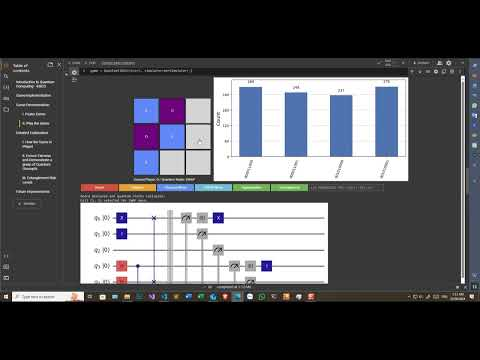

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('U6_wSh_-EQc', width=960, height=490)

## **Game Implementation**

In [3]:
!pip install qiskit --quiet
!pip install qiskit-aer --quiet
!pip install pylatexenc --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [8]:
# @markdown ### **1. Import `Qiskit` and essential packages for UI demonstration** { display-mode: "form" }
from abc import abstractmethod, ABCMeta # For define pure virtual functions
from IPython.display import clear_output
from ipywidgets import Output, Button, HBox, VBox, HTML, Dropdown
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit_aer import AerSimulator

In [40]:
# @markdown ### **2. `Board` class for essential quantum operations** { display-mode: "form" }
class Board:
    def __init__(self, size=3, simulator=None):
        # Initialize the quantum circuit with one qubit and classical bit for each cell
        self.size = size
        self.simulator = simulator
        self.superposition_count = 0
        self.cells = [[' ' for _ in range(size)] for _ in range(size)] # Initialize the board representation

        self.qubits = QuantumRegister(size**2, 'q')
        self.bits = ClassicalRegister(size**2, 'c')
        self.circuit = QuantumCircuit(self.qubits, self.bits)

        ''' For a 3x3 board, the winning lines are:
        - Horizontal lines: (0, 1, 2), (3, 4, 5), (6, 7, 8)
        - Vertical lines: (0, 3, 6), (1, 4, 7), (2, 5, 8)
        - Diagonal lines: (0, 4, 8), (2, 4, 6)
        '''
        self.winning_lines = [tuple(range(i, size**2, size)) for i in range(size)] + \
                             [tuple(range(i * size, (i + 1) * size)) for i in range(size)] + \
                             [tuple(range(0, size**2, size + 1)), tuple(range(size - 1, size**2 - 1, size - 1))]


    def make_classical_move(self, row, col, player_mark, is_collapsed=False):
        if self.cells[row][col] == ' ' or is_collapsed: # Check if the cell is occupied
            self.cells[row][col] = player_mark
            index = row * self.size + col

            if player_mark == 'X': self.circuit.x(self.qubits[index])
            else: self.circuit.id(self.qubits[index])
            return True
        return False


    def make_swap_move(self, row1, col1, row2, col2, **kwargs):
        if self.cells[row1][col1] != ' ' and self.cells[row2][col2] != ' ':
            indices = [row1 * self.size + col1, row2 * self.size + col2]
            self.circuit.swap(self.qubits[indices[0]], self.qubits[indices[1]])
            self.cells[row1][col1], self.cells[row2][col2] = self.cells[row2][col2], self.cells[row1][col1]
            return True
        return False


    def make_superposition_move(self, row, col, player_mark, **kwargs):
        if self.cells[row][col] == ' ':
            index = row * self.size + col
            self.circuit.h(self.qubits[index])
            self.cells[row][col] = player_mark + '?'
            self.superposition_count += 1
            return True
        return False


    def make_entangled_move(self, *positions, risk_level, player_mark, **kwargs):
        # Entangle the quantum states of 2 or 3 cells based on the risk level
        pos_count = len(positions)
        if pos_count not in [2, 3] or risk_level not in [1, 2, 3, 4] or len(set(positions)) != pos_count or \
            (pos_count == 2 and risk_level not in [1, 3]) or (pos_count == 3 and risk_level not in [2, 4]) or \
            any(self.cells[row][col] != ' ' for row, col in positions): return False

        indices = [row * self.size + col for row, col in positions]
        self.circuit.h(self.qubits[indices[0]])

        if pos_count == 2:
            # Pairwise Entanglement with Bell state for 2 qubits:
            # Lv1. |Ψ+⟩ = (∣01⟩ + ∣10⟩)/√2 | Lv3. |Φ+⟩ = (∣00⟩ + ∣11⟩)/√2
            if risk_level == 1: self.circuit.x(self.qubits[indices[1]])
            self.circuit.cx(self.qubits[indices[0]], self.qubits[indices[1]])
        else:
            # Triple Entanglement with GHZ state for 3 qubits:
            # Lv2. (∣010⟩ + ∣101⟩)/√2 | Lv4. (∣000⟩ + ∣111⟩)/√2
            if risk_level == 2:
                self.circuit.x(self.qubits[indices[1]])
                self.circuit.x(self.qubits[indices[2]])

            # Apply CNOT chain to entangle all 3 qubits
            self.circuit.cx(self.qubits[indices[0]], self.qubits[indices[1]])
            self.circuit.cx(self.qubits[indices[1]], self.qubits[indices[2]])

        for row, col in positions: self.cells[row][col] = player_mark + '?'
        self.superposition_count += pos_count
        return True


    def can_be_collapsed(self):
        # If superpositions/entanglement cells form a potential winning line => collapse
        for line in self.winning_lines:
            if all(self.cells[i // self.size][i % self.size].endswith('?') for i in line):
                return True
        return False


    def collapse_board(self):
        # Update the board based on the measurement results and apply the corresponding classical moves
        self.circuit.barrier()
        self.circuit.measure(self.qubits, self.bits) # Measure all qubits to collapse them to classical states

        transpiled_circuit = transpile(self.circuit, self.simulator)
        job = self.simulator.run(transpiled_circuit, memory=True)
        counts = job.result().get_counts()
        max_state = max(counts, key=counts.get)[::-1] # Get the state with the highest probability

        for i in range(self.size ** 2):
            row, col = divmod(i, self.size)
            if self.cells[row][col].endswith('?'):
                self.circuit.reset(self.qubits[i])
                self.make_classical_move(row, col, 'X' if max_state[i] == '1' else 'O', is_collapsed=True)

        self.superposition_count = 0
        return counts


    def check_win(self):
        # Dynamic implementation for above logic with dynamic winning lines
        for line in self.winning_lines:
            # Check if all cells in the line are the same and not empty
            first_cell = self.cells[line[0] // self.size][line[0] % self.size]
            if first_cell not in [' ', 'X?', 'O?']:
                is_same = all(self.cells[i // self.size][i % self.size] == first_cell for i in line)
                if is_same: return line

        # If no spaces and no superpositions left => 'Draw'
        # If all cells are filled but some are still in superpositions => collapse_board
        if all(self.cells[i // self.size][i % self.size] not in [' '] for i in range(self.size**2)):
            if self.superposition_count <= 0: return 'Draw'
            return self.superposition_count
        return None

In [10]:
# @markdown ### **3. `QuantumT3Widgets` class for game interface**
class QuantumT3Widgets(metaclass=ABCMeta):
    def __init__(self, board, current_player, quantum_move_mode):
        self.board = board
        self.current_player = current_player
        self.quantum_move_mode = quantum_move_mode

        self.log = Output(layout={'margin': '10px 0 0 0'})
        self.histogram_output = Output(layout={'margin': '0 0 10px 10px'})
        self.circuit_output = Output()
        self.create_widgets()


    def create_widgets(self):
        # Create widgets for each cell and controls for game actions
        self.buttons = []
        for row in range(self.board.size):
            self.buttons.append([])
            for col in range(self.board.size):
                button = Button(
                    description = ' ',
                    layout = {'width': '100px', 'height': '100px', 'border': '1px solid black'},
                    style = {'button_color': 'lightgray', 'font_weight': 'bold', 'text_color': 'white'}
                )
                button.on_click(self.create_on_cell_clicked(row, col))
                self.buttons[row].append(button)

        self.create_action_buttons()
        self.game_info = HTML(f'<b>Current Player: {self.current_player} / Quantum Mode: {self.quantum_move_mode}</b>')

        self.board_histogram_widget = HBox(
            [VBox([VBox([HBox(row) for row in self.buttons]), self.game_info]), self.histogram_output],
            layout = {'display': 'flex', 'justify_content': 'center', 'align_items': 'flex-end'}
        )
        display(VBox([self.board_histogram_widget, self.action_buttons, self.log, self.circuit_output]))


    def create_action_buttons(self):
        self.reset_btn = Button(description='Reset', button_style='danger')
        self.collapse_btn = Button(description='Collapse', button_style='warning')
        self.classical_btn = Button(description='Classical Move', button_style='primary')
        self.swap_btn = Button(description='SWAP Move', button_style='info')
        self.superposition_btn = Button(description='Superposition', button_style='success')

        self.entangled_btn = Button(description='Entanglement', button_style='success')
        self.entangled_options = Dropdown(options=[
            ('', 0), # Qubits collapse to opposite states (not consecutive)
            ('Lv1. PAIRWAISE: ∣Ψ+⟩ = (∣01⟩ + ∣10⟩) / √2', 1), # Qubits collapse to opposite states (not consecutive)
            ('Lv2. TRIPLE: GHZ_Xs = (∣010⟩ + ∣101⟩) / √2', 2),
            ('Lv3. PAIRWAISE: ∣Φ+⟩ = (∣00⟩ + ∣11⟩) / √2', 3), # Can form consecutive winning cells or accidentally help the opponent
            ('Lv4. TRIPLE: GHZ = (∣000⟩ + ∣111⟩) / √2', 4),
        ], value=0, disabled=True)
        self.entangled_options.observe(self.update_entangled_options, names='value')

        self.reset_btn.on_click(self.on_reset_btn_clicked)
        self.collapse_btn.on_click(self.on_collapse_btn_clicked)
        self.classical_btn.on_click(self.create_on_move_clicked('CLASSICAL'))
        self.swap_btn.on_click(self.create_on_move_clicked('SWAP', 'Select 2 cells to swap their states.'))
        self.superposition_btn.on_click(self.create_on_move_clicked('SUPERPOSITION', 'Select a cell to put in superposition.'))
        self.entangled_btn.on_click(self.create_on_move_clicked('ENTANGLED', 'Select 2/3 cells based on risk level to entangle.'))

        self.action_buttons = HBox([
            self.reset_btn, self.collapse_btn, self.classical_btn, self.swap_btn,
            self.superposition_btn, self.entangled_btn, self.entangled_options
        ])


    @abstractmethod # Pure virtual functions => Must be overridden in the derived classes
    def on_reset_btn_clicked(self, btn=None):
        raise NotImplementedError('on_reset_btn_clicked method is not implemented.')

    @abstractmethod # Pure virtual functions => Must be overridden in the derived classes
    def on_collapse_btn_clicked(self, btn=None):
        raise NotImplementedError('on_collapse_btn_clicked method is not implemented.')

    @abstractmethod # Pure virtual functions => Must be overridden in the derived classes
    def on_move_clicked(self, mode, message=''):
        raise NotImplementedError('on_move_clicked method is not implemented.')

    @abstractmethod # Pure virtual functions => Must be overridden in the derived classes
    def on_cell_clicked(self, btn, row, col):
        raise NotImplementedError('on_cell_clicked method is not implemented.')


    def update_entangled_options(self, change):
        with self.log:
            self.entangled_options.disabled = change.new != 0
            for row in self.buttons:
                for button in row: button.disabled = change.new == 0

            # Check if there are enough empty cells for the selected operation
            empty_count = sum(cell == ' ' for row in self.board.cells for cell in row)
            total_empty_required = {1: 2, 2: 3, 3: 2, 4: 3} # Total empty cells required for each risk level

            if change.new == 0: return
            elif empty_count < total_empty_required[change.new]:
                print(f'Not enough empty cells to perform entanglement with risk level {change.new}. Please select another.')
                self.entangled_options.value = 0
            else:
                print(f'Risk Level {change.new} ACTIVATED =>', end=' ')
                if change.new in [1, 3]: print(f'Select 2 cells (qubits) for this PAIRWAISE entanglement.')
                else: print(f'Select 3 cells (qubits) for this TRIPLE entanglement.')


    def create_on_move_clicked(self, mode, message=''):
        def on_move_clicked(btn):
            with self.log:
                try: self.on_move_clicked(mode, message)
                except Exception as e: print(f'ERROR: {e}')
        return on_move_clicked


    def create_on_cell_clicked(self, row, col):
        def on_cell_clicked(btn):
            with self.log:
                try: self.on_cell_clicked(btn, row, col)
                except Exception as e: print(f'ERROR: {e}')
        return on_cell_clicked


    def display_circuit(self):
        with self.circuit_output:
            clear_output(wait=True)
            display(self.board.circuit.draw('mpl', fold=-1, initial_state=True))


    def display_histogram(self, counts):
        with self.histogram_output:
            clear_output(wait=True)
            display(plot_histogram(counts, figsize=(9, 4)))

In [55]:
# @markdown ### **4. `QuantumT3GUI` class for game flow and interaction between players and `Board`**
class QuantumT3GUI(QuantumT3Widgets):
    def __init__(self, size=3, simulator=None):
        super().__init__(Board(size, simulator), 'X', 'CLASSICAL')
        self.quantum_moves_selected = [] # Selected cells for operation on multi-qubit gates
        self.game_over = False


    def buttons_disabled(self, is_disabled=True):
        for btn in self.action_buttons.children[1:]: btn.disabled = is_disabled
        for row in self.buttons:
            for btn in row: btn.disabled = is_disabled


    def update_entire_board(self):
        for row in range(self.board.size):
            for col in range(self.board.size):
                cell = self.board.cells[row][col]
                color_map = {'X': 'dodgerblue', 'O': 'purple', '?': 'green', ' ': 'lightgray'}
                self.buttons[row][col].description = cell if cell != ' ' else ' '
                self.buttons[row][col].style.button_color = color_map[cell[-1]]


    def clean_incompleted_quantum_moves(self):
        for row, col in self.quantum_moves_selected:
            if self.board.cells[row][col] == ' ':
                self.buttons[row][col].description = ' '
                self.buttons[row][col].style.button_color = 'lightgray'
        self.quantum_moves_selected = []


    def on_reset_btn_clicked(self, btn=None):
        with self.log:
            clear_output(wait=True)
            self.board = Board(self.board.size, self.board.simulator)
            self.current_player = 'X'
            self.quantum_move_mode = 'CLASSICAL'
            self.quantum_moves_selected = []
            self.game_info.value = f'<b>Current Player: {self.current_player} / Quantum Mode: {self.quantum_move_mode}</b>'
            self.game_over = False

            self.update_entire_board()
            self.buttons_disabled(False)
            self.entangled_options.disabled = True

            with self.histogram_output: clear_output()
            with self.circuit_output: clear_output()
            print('Game reset. New game started.')


    def on_collapse_btn_clicked(self, btn=None):
        with self.log:
            if self.quantum_moves_selected:
                print('Please complete the current quantum operation before measuring the board.')
                return

            clear_output(wait=True)
            counts = self.board.collapse_board()
            self.display_histogram(counts)
            self.update_entire_board() # Update the board cells with the collapsed states
            self.check_win()
            print('Board measured and quantum states collapsed.')


    def on_move_clicked(self, mode, message=''):
        clear_output(wait=True)
        self.quantum_move_mode = mode
        self.game_info.value = f'<b>Current Player: {self.current_player} / Quantum Mode: {self.quantum_move_mode}</b>'
        self.clean_incompleted_quantum_moves()

        for row in self.buttons:
            for button in row: button.disabled = mode == 'ENTANGLED'

        if mode == 'ENTANGLED': self.entangled_options.value = 0
        self.entangled_options.disabled = mode != 'ENTANGLED'
        print(f'{mode} mode ACTIVATED' + (f': {message}' if message else ''))


    def on_cell_clicked(self, btn, row, col):
        if self.quantum_move_mode == 'CLASSICAL':
            if self.board.make_classical_move(row, col, self.current_player):
                btn.description = self.board.cells[row][col]
                btn.style.button_color = 'dodgerblue' if self.current_player == 'X' else 'purple'
                self.check_win()
            else: print('That position is already occupied. Please choose another.')

        elif self.quantum_move_mode == 'SUPERPOSITION':
            if self.board.cells[row][col] == ' ':
                btn.description = self.current_player + '?'
                btn.style.button_color = 'green'
                self.make_quantum_move_wrapper(
                    pos=(row, col), board_func=self.board.make_superposition_move,
                    success_msg='Cell is now in superposition state.')
            else: print('Invalid SUPERPOSITION move. Cell must be empty.')

        elif len(self.quantum_moves_selected) < 3: # Multi-qubit gates operation
            self.quantum_moves_selected.append((row, col)) # Store the selected cell of operation
            print(f'Cell ({row + 1}, {col + 1}) selected for {self.quantum_move_mode} move.')

            if self.quantum_move_mode == 'SWAP' and len(self.quantum_moves_selected) == 2:
                flat_pos = sum(self.quantum_moves_selected, ()) # Flatten the tuple to match 4 arguments in Board.make_swap_move
                pos1, pos2 = self.quantum_moves_selected
                self.make_quantum_move_wrapper(
                    pos=flat_pos, board_func=self.board.make_swap_move,
                    success_msg=f'SWAPPED Cell {pos1} to {pos2}', success_func=self.swap_on_board,
                    failure_msg='Invalid SWAP move. Both cells must be non-empty.')

            elif self.quantum_move_mode == 'ENTANGLED':
                if self.board.cells[row][col] == ' ':
                    btn.description = self.current_player + '?'
                    btn.style.button_color = 'green'
                    total_empty_required = {1: 2, 2: 3, 3: 2, 4: 3} # Total empty cells required for each risk level

                    if len(self.quantum_moves_selected) == total_empty_required[self.entangled_options.value]:
                        self.make_quantum_move_wrapper(
                            pos=self.quantum_moves_selected, board_func=self.board.make_entangled_move,
                            success_msg='These positions are now entangled and in a superposition state.',
                            failure_msg='Invalid ENTANGLEMENT move. Duplicated cell selection.')
                else:
                    clear_output(wait=True)
                    print('Invalid ENTANGLEMENT move. A position is already occupied.')
                    self.quantum_moves_selected.pop() # Remove the invalid cell from the selected list


    def swap_on_board(self):
        row1, col1 = self.quantum_moves_selected[0][0], self.quantum_moves_selected[0][1]
        row2, col2 = self.quantum_moves_selected[1][0], self.quantum_moves_selected[1][1]

        # Swap the description and color of the selected cells
        self.buttons[row1][col1].description, self.buttons[row2][col2].description = \
            self.buttons[row2][col2].description, self.buttons[row1][col1].description
        self.buttons[row1][col1].style.button_color, self.buttons[row2][col2].style.button_color = \
            self.buttons[row2][col2].style.button_color, self.buttons[row1][col1].style.button_color


    def make_quantum_move_wrapper(self, pos, board_func, success_msg='', success_func=None, failure_msg=''):
        if board_func(*pos, risk_level=self.entangled_options.value, player_mark=self.current_player):
            if success_msg: print(success_msg)
            if success_func: success_func()
            if self.board.can_be_collapsed():
                print('Perform automatic board measurement and collapse the states.')
                self.quantum_moves_selected = []
                self.on_collapse_btn_clicked()
            else: self.check_win()
        else:
            clear_output(wait=True)
            if failure_msg: print(failure_msg)
            self.clean_incompleted_quantum_moves()


    def check_win(self):
        self.quantum_moves_selected = []
        while not self.game_over: # Check if the game is over after each move
            self.display_circuit()
            result = self.board.check_win()

            if result == 'Draw': # All cells are filled but no winner yet
                self.game_over = True
                print("Game Over. It's a draw!")

            elif type(result) == tuple: # A player wins
                self.game_over = True
                for cell_index in result:
                    row, col = divmod(cell_index, self.board.size)
                    self.buttons[row][col].style.button_color = 'orangered'
                print(f'Game Over. {self.board.cells[row][col]} wins!')

            elif type(result) == int: # All cells are filled but some are still in superpositions
                print(f'All cells are filled but {result} of them still in superpositions => Keep Collapsing...')
                self.quantum_moves_selected = []
                self.on_collapse_btn_clicked() # Automatically collapse the board
                break

            else: # Switch players if no winner yet then continue the game
                self.current_player = 'O' if self.current_player == 'X' else 'X' # Switch players
                self.game_info.value = f'<b>Current Player: {self.current_player} / Quantum Mode: {self.quantum_move_mode}</b>'
                break
        if self.game_over: self.buttons_disabled(True)


## **Play the Game**

In [56]:
game = QuantumT3GUI(size=3, simulator=AerSimulator())

## **Detailed Explanation**

### **I. How the Game is Played**


In this game, 2 players `X` and `O` is represented by 2 qubit classical states, $|1\rangle$ and $|0\rangle$ respectively. Therefore, the **Pauli-X** gate is used to flip $|0\rangle$ to $|1\rangle$ for player `X`, while the **Identity gate** represents player `O`'s unchanged state $|0\rangle$. Players can choose between making a **classical** move or **quantum** moves, leading to a range of possibilities upon measurement:

1. **Classical Move**: Each player alternates turns, placing their marker `X` or `O` on **1 unoccupied cell**.
2. **SWAP Move**: Apply the **SWAP** gate swap the states of **2 occupied cells** without adding new markers.
3. **Superposition**: Apply the **Hadamard** (H) gate to **1 unoccupied cell** (qubit), resulting in the $|+\rangle = \frac{|0\rangle + |1\rangle}{\sqrt{2}}$ state, which does not commit to `X` or `O` until the board is measured and collapsed.
4. **Entanglement**: Link **2 or 3 unoccupied cells**, affecting outcomes such that the final state of one cell will affect the other. Players must also carefully choose between **4 Risk Levels** (see below) based on their current position and potential future board states. Lower levels allow more controlled outcomes, while higher ones can gamble for a win or potentially aid the opponent.

The `X?` and `O?` markers will be used to indicate the cells are **superposed**/**entangled**, meaning their final values as `X` or `O` are not yet determined until a **measurement collapses** their states and capture the state with the **highest occurrence**. This can happen when:
- The board is **full**. If there are still several `X?`/`O?` cells, an **automatic collapse** will be performed to resolve all **superpositions**.
- Reaching a set of **superposed**/**entangled** cells forming a potential **winning line**.
- Manually triggered by the **Collapse** button press.

**[NOTE]**:
- If the board is **full** with no cells in **superposition** and also no winning lines, the game is `Draw`.
- If you want to make a new choice for **Entanglement Risk Levels**, just click the **Entanglement** button again.

### **II. Ensure Fairness and Demonstrate a grasp of Quantum Concepts**

At the begining, this game only has 3 options: **Classical move**, **Superpostion**, and **Entanglement** with the standard Bell state $|\Phi^+\rangle$. However, this **Entanglement** approach has 2 disadvantages.

- **Firstly**, when players selects **Entanglement** and picks 2 cells on the board, this will be unfair for their opponents as they will lose 1 move.

- **Secondly**, the **Bell** state $|\Phi^+\rangle$ represents a maximally entangled state where measurement outcomes are perfectly correlated ($|00\rangle$ or $|11\rangle$). This strategy can be risky as it could lead to either a winning line quicker or accidentally help the opponent. For example, if `X` players have a plan of entangling 2 consecutive cells, they can have:
    - Multiple `X` in a row, increasing their possibility of winning.
    - Multiple `O` in a row, putting them at risk of losing as their `O` opponents now have more consecutive cells than them.

**Therefore, to overcome these**:
- I introduce the **SWAP Move**, which can disrupt existing lines or defenses in the opponent's strategy, limiting players from overusing **Entanglement** to dominate the game unfairly.
- Moreover, I introduce **4 Entangelement Risk Levels** to add strategic depth and requiring players to think critically about the consequences of their quantum moves:
    - By adding an **Pauli-X** gate before the **CNOT**'s target qubit, I turned the Bell state $|\Phi^+\rangle$ into $|\Psi^+\rangle$, which also represents a maximally entangled state but with opposing outcomes, ensuring a 50/50 chance and reducing the above risk of $|\Phi^+\rangle$.
    - Similarly, I further employed the same approach for **Triple Entanglement** and turn the **Standard $|GHZ\rangle$** state into $|GHZ_{Xs}\rangle$ by applying 2 additional **Pauli-X** before the **CNOT** chains of **2 targeted** qubit components.

### **III. Entanglement Risk Levels**

There are 2 types of **Entanglements** in this game associated with 4 corresponding **Risk Levels**:

- **Pairwise Entanglement**: A player can entangle **2** empty cells, meaning the state of 1 cell depends on the state of the other, and their final states (either `X`or `O`) aren't determined until a measurement is performed.
- **Triple Entanglement**: Advanced moves allow entangling **3** cells simultaneously.

<br>

<table>
<tr>
<th>Risk Level (Select via the "Dropdown")</th>
<th>Quantum Gates</th>
<th>Example Circuit</th>
<th>Effect on Measurement and Collapse</th>
</tr>
<tr>
<td align="center"><b>Lv1. Lowest Risk<b><br><br>$|\Psi^+\rangle = \frac{|01\rangle + |10\rangle}{\sqrt{2}}$<br><br>(Pairwise Entangle)</td>
<td align="center">Hadamard (H),<br><br>Pauli-X (X),<br><br>CNOT (CX)</td>
<td>

```
     ┌───┐
q_0: ┤ H ├──■──
     ├───┤┌─┴─┐
q_1: ┤ X ├┤ X ├
     └───┘└───┘
```
</td>
<td>This <b>Bell</b> state results in anti-correlated and truly random outcomes upon collapse.<br><br>When one qubit collapses to <b>X</b>, the other must collapse to <b>O</b>, and vice versa.</td>

</tr>
<tr>
<td align="center"><b>Lv2. Lower Risk<b><br><br>$|GHZ_{Xs}\rangle = \frac{|010\rangle + |101\rangle}{\sqrt{2}}$<br><br>(Triple Entangle)</td>
<td align="center">Hadamard (H),<br><br>2 Pauli-X (X),<br><br>2 CNOT (CX)</td>
<td>

```
     ┌───┐
q_0: ┤ H ├──■───────
     ├───┤┌─┴─┐
q_1: ┤ X ├┤ X ├──■──
     ├───┤└───┘┌─┴─┐
q_2: ┤ X ├─────┤ X ├
     └───┘     └───┘
```
</td>
<td>Similar randomness but for 3 squares, formed by modifying the <b>Standard $|GHZ\rangle$,</b><br><br>leading to combinations where the outcome isn't uniformly all 3 <b>X</b>s or all <b>O</b>s, but mixed.<br></td>
</tr>

<tr>
<td align="center"><b>Lv3. Moderate Risk<b><br><br>$|\Phi^+\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}$<br><br>(Pairwise Entangle)</td>
<td align="center">Hadamard (H),<br><br>CNOT (CX)</td>
<td>

```
     ┌───┐
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘
```
</td>
<td>This <b>Bell</b> state yields the same outcome for both selected cells/qubits.<br><br>Both qubits collapse to the same value upon measurement, either <b>XX</b> or <b>OO</b>.<td>
</tr>

<tr>
<td align="center"><b>Lv4. High Risk<b><br><br>$|GHZ\rangle = \frac{|000\rangle + |111\rangle}{\sqrt{2}}$<br><br>(Triple Entangle)</td>
<td align="center">Hadamard (H),<br><br>2 CNOT (CX)</td>
<td>

```
     ┌───┐
q_0: ┤ H ├──■───────
     └───┘┌─┴─┐
q_1: ─────┤ X ├──■──
          └───┘┌─┴─┐
q_2: ──────────┤ X ├
               └───┘
```
</td>
<td>This <b>Standard $|GHZ\rangle$</b> state can strategically benefit the player<br><br>but also at the risk of benefiting the opponent just as much.<br><br>All 3 qubits collapse to the same value, either all <b>XXX</b> or all <b>OOO</b>.</td>
</tr>
</table>


## **Future Improvements**

- Limit the **Entanglement Risk Levels** based on the board size. For example, **3x3** board can only use **PAIRWISE** entanglement (Level `1` & `3`). Because if they use `2` or `4`, they can win or lose the game in 1 move.
- Count the number of **winning lines** for each player as a score to demonstrate how confident the winner is or to determine the winner if the game is a **draw**.
- Apply phase shift gates like **S** or **T** gates before making a move. This could affect the probability **amplitudes** of the states, creating **interference** patterns in probabilities.
- Implement the `Undo` and `Redo` functionalities for the game. But this is a bit complex for cases like entanglement or after collapsing.
- Develop an `AI` opponent that adapatively uses quantum strategies, learning from the player's moves.